# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-pack

## Configurations

In [2]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ShapesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [5]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

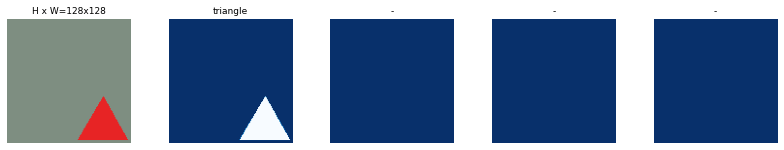

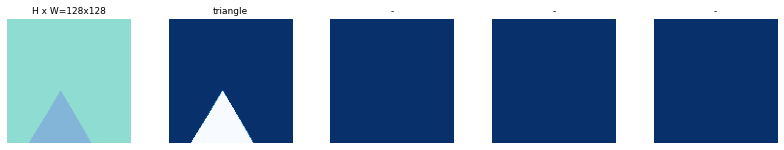

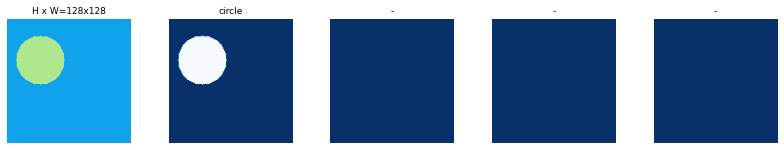

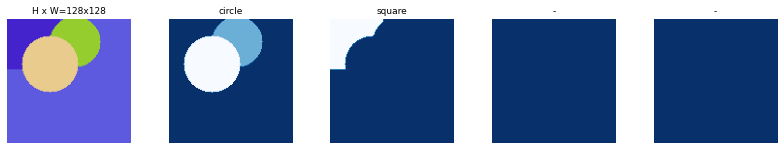

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/cha/git/Mask_RCNN/logs/shapes20230508T1602/mask_rcnn_shapes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_ma

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from vers

Epoch 1/1


/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

  1/100 [..............................] - ETA: 1109s - loss: 8.8199 - rpn_class_loss: 0.0701 - rpn_bbox_loss: 2.1497 - mrcnn_class_loss: 3.4686 - mrcnn_bbox_loss: 1.7643 - mrcnn_mask_loss: 1.3672

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

  2/100 [..............................] - ETA: 876s - loss: 8.4994 - rpn_class_loss: 0.0813 - rpn_bbox_loss: 2.3331 - mrcnn_class_loss: 3.1714 - mrcnn_bbox_loss: 1.6826 - mrcnn_mask_loss: 1.2311 

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

  3/100 [..............................] - ETA: 795s - loss: 8.3409 - rpn_class_loss: 0.0917 - rpn_bbox_loss: 2.5693 - mrcnn_class_loss: 2.8688 - mrcnn_bbox_loss: 1.6958 - mrcnn_mask_loss: 1.1154

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

  4/100 [>.............................] - ETA: 751s - loss: 7.6772 - rpn_class_loss: 0.0885 - rpn_bbox_loss: 2.4804 - mrcnn_class_loss: 2.4199 - mrcnn_bbox_loss: 1.6378 - mrcnn_mask_loss: 1.0506

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

  5/100 [>.............................] - ETA: 723s - loss: 7.3560 - rpn_class_loss: 0.0838 - rpn_bbox_loss: 2.3730 - mrcnn_class_loss: 2.1324 - mrcnn_bbox_loss: 1.5862 - mrcnn_mask_loss: 1.1806

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

  6/100 [>.............................] - ETA: 701s - loss: 7.0162 - rpn_class_loss: 0.0829 - rpn_bbox_loss: 2.2357 - mrcnn_class_loss: 1.9982 - mrcnn_bbox_loss: 1.5007 - mrcnn_mask_loss: 1.1987

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

  7/100 [=>............................] - ETA: 684s - loss: 6.8001 - rpn_class_loss: 0.0882 - rpn_bbox_loss: 2.1384 - mrcnn_class_loss: 1.9748 - mrcnn_bbox_loss: 1.4373 - mrcnn_mask_loss: 1.1614

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

  8/100 [=>............................] - ETA: 668s - loss: 6.4935 - rpn_class_loss: 0.0860 - rpn_bbox_loss: 2.0717 - mrcnn_class_loss: 1.8249 - mrcnn_bbox_loss: 1.3782 - mrcnn_mask_loss: 1.1327

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

  9/100 [=>............................] - ETA: 653s - loss: 6.1897 - rpn_class_loss: 0.0853 - rpn_bbox_loss: 1.9668 - mrcnn_class_loss: 1.7345 - mrcnn_bbox_loss: 1.3026 - mrcnn_mask_loss: 1.1006

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 10/100 [==>...........................] - ETA: 640s - loss: 5.9234 - rpn_class_loss: 0.0838 - rpn_bbox_loss: 1.8567 - mrcnn_class_loss: 1.6575 - mrcnn_bbox_loss: 1.2527 - mrcnn_mask_loss: 1.0728

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 11/100 [==>...........................] - ETA: 629s - loss: 5.7190 - rpn_class_loss: 0.0828 - rpn_bbox_loss: 1.7975 - mrcnn_class_loss: 1.5855 - mrcnn_bbox_loss: 1.2139 - mrcnn_mask_loss: 1.0393

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 12/100 [==>...........................] - ETA: 619s - loss: 5.5119 - rpn_class_loss: 0.0796 - rpn_bbox_loss: 1.7517 - mrcnn_class_loss: 1.5039 - mrcnn_bbox_loss: 1.1791 - mrcnn_mask_loss: 0.9975

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 13/100 [==>...........................] - ETA: 609s - loss: 5.3804 - rpn_class_loss: 0.0802 - rpn_bbox_loss: 1.7286 - mrcnn_class_loss: 1.4389 - mrcnn_bbox_loss: 1.1611 - mrcnn_mask_loss: 0.9717

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 14/100 [===>..........................] - ETA: 600s - loss: 5.1921 - rpn_class_loss: 0.0796 - rpn_bbox_loss: 1.6579 - mrcnn_class_loss: 1.3752 - mrcnn_bbox_loss: 1.1298 - mrcnn_mask_loss: 0.9497

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 15/100 [===>..........................] - ETA: 591s - loss: 5.0528 - rpn_class_loss: 0.0783 - rpn_bbox_loss: 1.6126 - mrcnn_class_loss: 1.3193 - mrcnn_bbox_loss: 1.1100 - mrcnn_mask_loss: 0.9327

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 16/100 [===>..........................] - ETA: 583s - loss: 4.9158 - rpn_class_loss: 0.0759 - rpn_bbox_loss: 1.5626 - mrcnn_class_loss: 1.2665 - mrcnn_bbox_loss: 1.0862 - mrcnn_mask_loss: 0.9245

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 17/100 [====>.........................] - ETA: 575s - loss: 4.7841 - rpn_class_loss: 0.0743 - rpn_bbox_loss: 1.5059 - mrcnn_class_loss: 1.2279 - mrcnn_bbox_loss: 1.0644 - mrcnn_mask_loss: 0.9115

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 18/100 [====>.........................] - ETA: 566s - loss: 4.6724 - rpn_class_loss: 0.0746 - rpn_bbox_loss: 1.4696 - mrcnn_class_loss: 1.1895 - mrcnn_bbox_loss: 1.0399 - mrcnn_mask_loss: 0.8988

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 19/100 [====>.........................] - ETA: 559s - loss: 4.5601 - rpn_class_loss: 0.0732 - rpn_bbox_loss: 1.4306 - mrcnn_class_loss: 1.1527 - mrcnn_bbox_loss: 1.0183 - mrcnn_mask_loss: 0.8853

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 20/100 [=====>........................] - ETA: 550s - loss: 4.4580 - rpn_class_loss: 0.0724 - rpn_bbox_loss: 1.4050 - mrcnn_class_loss: 1.1168 - mrcnn_bbox_loss: 0.9946 - mrcnn_mask_loss: 0.8691

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 21/100 [=====>........................] - ETA: 543s - loss: 4.3696 - rpn_class_loss: 0.0720 - rpn_bbox_loss: 1.3859 - mrcnn_class_loss: 1.0823 - mrcnn_bbox_loss: 0.9775 - mrcnn_mask_loss: 0.8518

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 22/100 [=====>........................] - ETA: 535s - loss: 4.2757 - rpn_class_loss: 0.0715 - rpn_bbox_loss: 1.3516 - mrcnn_class_loss: 1.0544 - mrcnn_bbox_loss: 0.9587 - mrcnn_mask_loss: 0.8394

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 23/100 [=====>........................] - ETA: 527s - loss: 4.1949 - rpn_class_loss: 0.0707 - rpn_bbox_loss: 1.3235 - mrcnn_class_loss: 1.0325 - mrcnn_bbox_loss: 0.9412 - mrcnn_mask_loss: 0.8271

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 24/100 [======>.......................] - ETA: 520s - loss: 4.1150 - rpn_class_loss: 0.0700 - rpn_bbox_loss: 1.3107 - mrcnn_class_loss: 1.0021 - mrcnn_bbox_loss: 0.9199 - mrcnn_mask_loss: 0.8123

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 25/100 [======>.......................] - ETA: 513s - loss: 4.0317 - rpn_class_loss: 0.0688 - rpn_bbox_loss: 1.2792 - mrcnn_class_loss: 0.9775 - mrcnn_bbox_loss: 0.9034 - mrcnn_mask_loss: 0.8029

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 26/100 [======>.......................] - ETA: 505s - loss: 3.9555 - rpn_class_loss: 0.0677 - rpn_bbox_loss: 1.2532 - mrcnn_class_loss: 0.9544 - mrcnn_bbox_loss: 0.8877 - mrcnn_mask_loss: 0.7925

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 27/100 [=======>......................] - ETA: 498s - loss: 3.8986 - rpn_class_loss: 0.0671 - rpn_bbox_loss: 1.2385 - mrcnn_class_loss: 0.9368 - mrcnn_bbox_loss: 0.8745 - mrcnn_mask_loss: 0.7817

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 28/100 [=======>......................] - ETA: 491s - loss: 3.8229 - rpn_class_loss: 0.0659 - rpn_bbox_loss: 1.2087 - mrcnn_class_loss: 0.9162 - mrcnn_bbox_loss: 0.8603 - mrcnn_mask_loss: 0.7717

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 29/100 [=======>......................] - ETA: 484s - loss: 3.7549 - rpn_class_loss: 0.0648 - rpn_bbox_loss: 1.1836 - mrcnn_class_loss: 0.8994 - mrcnn_bbox_loss: 0.8441 - mrcnn_mask_loss: 0.7631

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 30/100 [========>.....................] - ETA: 476s - loss: 3.6948 - rpn_class_loss: 0.0638 - rpn_bbox_loss: 1.1658 - mrcnn_class_loss: 0.8808 - mrcnn_bbox_loss: 0.8303 - mrcnn_mask_loss: 0.7541

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 31/100 [========>.....................] - ETA: 469s - loss: 3.6364 - rpn_class_loss: 0.0626 - rpn_bbox_loss: 1.1504 - mrcnn_class_loss: 0.8634 - mrcnn_bbox_loss: 0.8153 - mrcnn_mask_loss: 0.7446

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 32/100 [========>.....................] - ETA: 462s - loss: 3.5826 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 1.1381 - mrcnn_class_loss: 0.8429 - mrcnn_bbox_loss: 0.8037 - mrcnn_mask_loss: 0.7361

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 33/100 [========>.....................] - ETA: 455s - loss: 3.5219 - rpn_class_loss: 0.0609 - rpn_bbox_loss: 1.1168 - mrcnn_class_loss: 0.8268 - mrcnn_bbox_loss: 0.7886 - mrcnn_mask_loss: 0.7288

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 34/100 [=========>....................] - ETA: 448s - loss: 3.4733 - rpn_class_loss: 0.0605 - rpn_bbox_loss: 1.1039 - mrcnn_class_loss: 0.8102 - mrcnn_bbox_loss: 0.7771 - mrcnn_mask_loss: 0.7216

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 35/100 [=========>....................] - ETA: 441s - loss: 3.4310 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 1.0933 - mrcnn_class_loss: 0.7954 - mrcnn_bbox_loss: 0.7664 - mrcnn_mask_loss: 0.7158

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 36/100 [=========>....................] - ETA: 434s - loss: 3.3767 - rpn_class_loss: 0.0591 - rpn_bbox_loss: 1.0735 - mrcnn_class_loss: 0.7822 - mrcnn_bbox_loss: 0.7537 - mrcnn_mask_loss: 0.7082

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 37/100 [==========>...................] - ETA: 427s - loss: 3.3281 - rpn_class_loss: 0.0582 - rpn_bbox_loss: 1.0554 - mrcnn_class_loss: 0.7695 - mrcnn_bbox_loss: 0.7432 - mrcnn_mask_loss: 0.7019

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 38/100 [==========>...................] - ETA: 420s - loss: 3.2815 - rpn_class_loss: 0.0571 - rpn_bbox_loss: 1.0385 - mrcnn_class_loss: 0.7553 - mrcnn_bbox_loss: 0.7342 - mrcnn_mask_loss: 0.6964

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 39/100 [==========>...................] - ETA: 413s - loss: 3.2447 - rpn_class_loss: 0.0564 - rpn_bbox_loss: 1.0252 - mrcnn_class_loss: 0.7467 - mrcnn_bbox_loss: 0.7242 - mrcnn_mask_loss: 0.6922

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 40/100 [===========>..................] - ETA: 406s - loss: 3.2052 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 1.0123 - mrcnn_class_loss: 0.7366 - mrcnn_bbox_loss: 0.7148 - mrcnn_mask_loss: 0.6862

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 41/100 [===========>..................] - ETA: 399s - loss: 3.1622 - rpn_class_loss: 0.0545 - rpn_bbox_loss: 0.9980 - mrcnn_class_loss: 0.7241 - mrcnn_bbox_loss: 0.7054 - mrcnn_mask_loss: 0.6801

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 42/100 [===========>..................] - ETA: 392s - loss: 3.1186 - rpn_class_loss: 0.0536 - rpn_bbox_loss: 0.9823 - mrcnn_class_loss: 0.7128 - mrcnn_bbox_loss: 0.6961 - mrcnn_mask_loss: 0.6738

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 43/100 [===========>..................] - ETA: 385s - loss: 3.0887 - rpn_class_loss: 0.0530 - rpn_bbox_loss: 0.9702 - mrcnn_class_loss: 0.7059 - mrcnn_bbox_loss: 0.6896 - mrcnn_mask_loss: 0.6701

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 44/100 [============>.................] - ETA: 378s - loss: 3.0563 - rpn_class_loss: 0.0522 - rpn_bbox_loss: 0.9607 - mrcnn_class_loss: 0.6977 - mrcnn_bbox_loss: 0.6817 - mrcnn_mask_loss: 0.6641

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 45/100 [============>.................] - ETA: 371s - loss: 3.0170 - rpn_class_loss: 0.0514 - rpn_bbox_loss: 0.9481 - mrcnn_class_loss: 0.6871 - mrcnn_bbox_loss: 0.6719 - mrcnn_mask_loss: 0.6584

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 46/100 [============>.................] - ETA: 364s - loss: 2.9805 - rpn_class_loss: 0.0507 - rpn_bbox_loss: 0.9362 - mrcnn_class_loss: 0.6772 - mrcnn_bbox_loss: 0.6629 - mrcnn_mask_loss: 0.6535

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 47/100 [=============>................] - ETA: 357s - loss: 2.9453 - rpn_class_loss: 0.0501 - rpn_bbox_loss: 0.9271 - mrcnn_class_loss: 0.6661 - mrcnn_bbox_loss: 0.6544 - mrcnn_mask_loss: 0.6476

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 48/100 [=============>................] - ETA: 350s - loss: 2.9144 - rpn_class_loss: 0.0493 - rpn_bbox_loss: 0.9192 - mrcnn_class_loss: 0.6569 - mrcnn_bbox_loss: 0.6462 - mrcnn_mask_loss: 0.6428

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 49/100 [=============>................] - ETA: 344s - loss: 2.8889 - rpn_class_loss: 0.0489 - rpn_bbox_loss: 0.9122 - mrcnn_class_loss: 0.6502 - mrcnn_bbox_loss: 0.6397 - mrcnn_mask_loss: 0.6379

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 50/100 [==============>...............] - ETA: 337s - loss: 2.8610 - rpn_class_loss: 0.0483 - rpn_bbox_loss: 0.9026 - mrcnn_class_loss: 0.6439 - mrcnn_bbox_loss: 0.6327 - mrcnn_mask_loss: 0.6335

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 51/100 [==============>...............] - ETA: 330s - loss: 2.8316 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 0.8928 - mrcnn_class_loss: 0.6364 - mrcnn_bbox_loss: 0.6267 - mrcnn_mask_loss: 0.6279

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 52/100 [==============>...............] - ETA: 323s - loss: 2.8028 - rpn_class_loss: 0.0472 - rpn_bbox_loss: 0.8834 - mrcnn_class_loss: 0.6288 - mrcnn_bbox_loss: 0.6193 - mrcnn_mask_loss: 0.6240

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 53/100 [==============>...............] - ETA: 316s - loss: 2.7691 - rpn_class_loss: 0.0467 - rpn_bbox_loss: 0.8731 - mrcnn_class_loss: 0.6194 - mrcnn_bbox_loss: 0.6114 - mrcnn_mask_loss: 0.6185

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 54/100 [===============>..............] - ETA: 309s - loss: 2.7425 - rpn_class_loss: 0.0461 - rpn_bbox_loss: 0.8670 - mrcnn_class_loss: 0.6121 - mrcnn_bbox_loss: 0.6045 - mrcnn_mask_loss: 0.6128

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 55/100 [===============>..............] - ETA: 303s - loss: 2.7254 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 0.8633 - mrcnn_class_loss: 0.6072 - mrcnn_bbox_loss: 0.6000 - mrcnn_mask_loss: 0.6092

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 56/100 [===============>..............] - ETA: 296s - loss: 2.7027 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 0.8565 - mrcnn_class_loss: 0.6015 - mrcnn_bbox_loss: 0.5945 - mrcnn_mask_loss: 0.6050

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 57/100 [================>.............] - ETA: 289s - loss: 2.6774 - rpn_class_loss: 0.0447 - rpn_bbox_loss: 0.8478 - mrcnn_class_loss: 0.5958 - mrcnn_bbox_loss: 0.5883 - mrcnn_mask_loss: 0.6006

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 58/100 [================>.............] - ETA: 282s - loss: 2.6523 - rpn_class_loss: 0.0444 - rpn_bbox_loss: 0.8413 - mrcnn_class_loss: 0.5890 - mrcnn_bbox_loss: 0.5823 - mrcnn_mask_loss: 0.5954

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 59/100 [================>.............] - ETA: 276s - loss: 2.6270 - rpn_class_loss: 0.0439 - rpn_bbox_loss: 0.8355 - mrcnn_class_loss: 0.5813 - mrcnn_bbox_loss: 0.5762 - mrcnn_mask_loss: 0.5900

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 60/100 [=================>............] - ETA: 269s - loss: 2.6080 - rpn_class_loss: 0.0435 - rpn_bbox_loss: 0.8308 - mrcnn_class_loss: 0.5757 - mrcnn_bbox_loss: 0.5708 - mrcnn_mask_loss: 0.5873

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 61/100 [=================>............] - ETA: 262s - loss: 2.5905 - rpn_class_loss: 0.0431 - rpn_bbox_loss: 0.8251 - mrcnn_class_loss: 0.5721 - mrcnn_bbox_loss: 0.5668 - mrcnn_mask_loss: 0.5834

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 62/100 [=================>............] - ETA: 255s - loss: 2.5693 - rpn_class_loss: 0.0427 - rpn_bbox_loss: 0.8184 - mrcnn_class_loss: 0.5666 - mrcnn_bbox_loss: 0.5616 - mrcnn_mask_loss: 0.5801

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 63/100 [=================>............] - ETA: 249s - loss: 2.5461 - rpn_class_loss: 0.0422 - rpn_bbox_loss: 0.8120 - mrcnn_class_loss: 0.5596 - mrcnn_bbox_loss: 0.5565 - mrcnn_mask_loss: 0.5758

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 64/100 [==================>...........] - ETA: 242s - loss: 2.5257 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 0.8079 - mrcnn_class_loss: 0.5532 - mrcnn_bbox_loss: 0.5512 - mrcnn_mask_loss: 0.5715

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 65/100 [==================>...........] - ETA: 235s - loss: 2.5016 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.8003 - mrcnn_class_loss: 0.5475 - mrcnn_bbox_loss: 0.5457 - mrcnn_mask_loss: 0.5667

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 66/100 [==================>...........] - ETA: 228s - loss: 2.4805 - rpn_class_loss: 0.0410 - rpn_bbox_loss: 0.7962 - mrcnn_class_loss: 0.5410 - mrcnn_bbox_loss: 0.5406 - mrcnn_mask_loss: 0.5617

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 67/100 [===================>..........] - ETA: 222s - loss: 2.4620 - rpn_class_loss: 0.0406 - rpn_bbox_loss: 0.7917 - mrcnn_class_loss: 0.5351 - mrcnn_bbox_loss: 0.5365 - mrcnn_mask_loss: 0.5580

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 68/100 [===================>..........] - ETA: 215s - loss: 2.4399 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 0.7860 - mrcnn_class_loss: 0.5286 - mrcnn_bbox_loss: 0.5312 - mrcnn_mask_loss: 0.5540

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 69/100 [===================>..........] - ETA: 208s - loss: 2.4211 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 0.7817 - mrcnn_class_loss: 0.5231 - mrcnn_bbox_loss: 0.5264 - mrcnn_mask_loss: 0.5501

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 70/100 [====================>.........] - ETA: 201s - loss: 2.4003 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.7769 - mrcnn_class_loss: 0.5172 - mrcnn_bbox_loss: 0.5211 - mrcnn_mask_loss: 0.5456

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 71/100 [====================>.........] - ETA: 195s - loss: 2.3804 - rpn_class_loss: 0.0392 - rpn_bbox_loss: 0.7722 - mrcnn_class_loss: 0.5117 - mrcnn_bbox_loss: 0.5162 - mrcnn_mask_loss: 0.5411

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 72/100 [====================>.........] - ETA: 188s - loss: 2.3629 - rpn_class_loss: 0.0389 - rpn_bbox_loss: 0.7675 - mrcnn_class_loss: 0.5065 - mrcnn_bbox_loss: 0.5123 - mrcnn_mask_loss: 0.5377

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 73/100 [====================>.........] - ETA: 181s - loss: 2.3451 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.7634 - mrcnn_class_loss: 0.5010 - mrcnn_bbox_loss: 0.5085 - mrcnn_mask_loss: 0.5336

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 74/100 [=====================>........] - ETA: 175s - loss: 2.3305 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 0.7598 - mrcnn_class_loss: 0.4968 - mrcnn_bbox_loss: 0.5050 - mrcnn_mask_loss: 0.5305

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 75/100 [=====================>........] - ETA: 168s - loss: 2.3127 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 0.7544 - mrcnn_class_loss: 0.4921 - mrcnn_bbox_loss: 0.5013 - mrcnn_mask_loss: 0.5268

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 76/100 [=====================>........] - ETA: 161s - loss: 2.2958 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.7494 - mrcnn_class_loss: 0.4877 - mrcnn_bbox_loss: 0.4976 - mrcnn_mask_loss: 0.5234

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 77/100 [======================>.......] - ETA: 154s - loss: 2.2821 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 0.7468 - mrcnn_class_loss: 0.4836 - mrcnn_bbox_loss: 0.4943 - mrcnn_mask_loss: 0.5197

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 78/100 [======================>.......] - ETA: 148s - loss: 2.2661 - rpn_class_loss: 0.0374 - rpn_bbox_loss: 0.7426 - mrcnn_class_loss: 0.4800 - mrcnn_bbox_loss: 0.4903 - mrcnn_mask_loss: 0.5158

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 79/100 [======================>.......] - ETA: 141s - loss: 2.2515 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.7388 - mrcnn_class_loss: 0.4759 - mrcnn_bbox_loss: 0.4869 - mrcnn_mask_loss: 0.5127

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 80/100 [=======================>......] - ETA: 134s - loss: 2.2378 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.7358 - mrcnn_class_loss: 0.4718 - mrcnn_bbox_loss: 0.4839 - mrcnn_mask_loss: 0.5094

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 81/100 [=======================>......] - ETA: 127s - loss: 2.2234 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.7314 - mrcnn_class_loss: 0.4678 - mrcnn_bbox_loss: 0.4810 - mrcnn_mask_loss: 0.5066

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 82/100 [=======================>......] - ETA: 121s - loss: 2.2104 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.7291 - mrcnn_class_loss: 0.4639 - mrcnn_bbox_loss: 0.4779 - mrcnn_mask_loss: 0.5031

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 83/100 [=======================>......] - ETA: 114s - loss: 2.1970 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.7262 - mrcnn_class_loss: 0.4600 - mrcnn_bbox_loss: 0.4748 - mrcnn_mask_loss: 0.4998

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 84/100 [========================>.....] - ETA: 107s - loss: 2.1796 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.7219 - mrcnn_class_loss: 0.4552 - mrcnn_bbox_loss: 0.4708 - mrcnn_mask_loss: 0.4958

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 85/100 [========================>.....] - ETA: 100s - loss: 2.1654 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.7198 - mrcnn_class_loss: 0.4507 - mrcnn_bbox_loss: 0.4670 - mrcnn_mask_loss: 0.4921

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 86/100 [========================>.....] - ETA: 94s - loss: 2.1540 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.7177 - mrcnn_class_loss: 0.4475 - mrcnn_bbox_loss: 0.4640 - mrcnn_mask_loss: 0.4893 

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 87/100 [=========================>....] - ETA: 87s - loss: 2.1401 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.7147 - mrcnn_class_loss: 0.4441 - mrcnn_bbox_loss: 0.4604 - mrcnn_mask_loss: 0.4856

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 88/100 [=========================>....] - ETA: 80s - loss: 2.1265 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 0.7118 - mrcnn_class_loss: 0.4406 - mrcnn_bbox_loss: 0.4568 - mrcnn_mask_loss: 0.4822

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 89/100 [=========================>....] - ETA: 73s - loss: 2.1120 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.7087 - mrcnn_class_loss: 0.4367 - mrcnn_bbox_loss: 0.4532 - mrcnn_mask_loss: 0.4786

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 90/100 [==========================>...] - ETA: 67s - loss: 2.0992 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.7059 - mrcnn_class_loss: 0.4327 - mrcnn_bbox_loss: 0.4504 - mrcnn_mask_loss: 0.4755

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 91/100 [==========================>...] - ETA: 60s - loss: 2.0864 - rpn_class_loss: 0.0345 - rpn_bbox_loss: 0.7040 - mrcnn_class_loss: 0.4288 - mrcnn_bbox_loss: 0.4470 - mrcnn_mask_loss: 0.4722

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 92/100 [==========================>...] - ETA: 53s - loss: 2.0733 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.7004 - mrcnn_class_loss: 0.4253 - mrcnn_bbox_loss: 0.4437 - mrcnn_mask_loss: 0.4697

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 93/100 [==========================>...] - ETA: 46s - loss: 2.0626 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.6990 - mrcnn_class_loss: 0.4216 - mrcnn_bbox_loss: 0.4409 - mrcnn_mask_loss: 0.4671

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 94/100 [===========================>..] - ETA: 40s - loss: 2.0506 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.6964 - mrcnn_class_loss: 0.4179 - mrcnn_bbox_loss: 0.4381 - mrcnn_mask_loss: 0.4642

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 95/100 [===========================>..] - ETA: 33s - loss: 2.0374 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.6924 - mrcnn_class_loss: 0.4146 - mrcnn_bbox_loss: 0.4352 - mrcnn_mask_loss: 0.4614

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 96/100 [===========================>..] - ETA: 26s - loss: 2.0238 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.6884 - mrcnn_class_loss: 0.4114 - mrcnn_bbox_loss: 0.4322 - mrcnn_mask_loss: 0.4583

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 97/100 [============================>.] - ETA: 20s - loss: 2.0127 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.6858 - mrcnn_class_loss: 0.4084 - mrcnn_bbox_loss: 0.4296 - mrcnn_mask_loss: 0.4556

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 98/100 [============================>.] - ETA: 13s - loss: 2.0011 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.6832 - mrcnn_class_loss: 0.4054 - mrcnn_bbox_loss: 0.4266 - mrcnn_mask_loss: 0.4528

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

 99/100 [============================>.] - ETA: 6s - loss: 1.9911 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.6816 - mrcnn_class_loss: 0.4022 - mrcnn_bbox_loss: 0.4243 - mrcnn_mask_loss: 0.4501 

/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/home/cha/.pyenv/versions/3.6.9/lib/python3.6/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set or

100/100 [==============================] - 697s - loss: 1.9827 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 0.6794 - mrcnn_class_loss: 0.4001 - mrcnn_bbox_loss: 0.4222 - mrcnn_mask_loss: 0.4480 - val_loss: 1.0069 - val_rpn_class_loss: 0.0182 - val_rpn_bbox_loss: 0.4450 - val_mrcnn_class_loss: 0.1275 - val_mrcnn_bbox_loss: 0.1990 - val_mrcnn_mask_loss: 0.2172


In [9]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

Checkpoint Path:  /deepmatter/mask_rcnn/logs/shapes2017102802/mask_rcnn_{epoch:04d}.h5
Starting at epoch 0. LR=0.0002

Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a_branch2b      

/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:1987: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/1
100/100 [==============================] - 86s - loss: 11.4006 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.8409 - mrcnn_class_loss: 0.1576 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1977 - val_loss: 11.4376 - val_rpn_class_loss: 0.0220 - val_rpn_bbox_loss: 1.0068 - val_mrcnn_class_loss: 0.1172 - val_mrcnn_bbox_loss: 0.0683 - val_mrcnn_mask_loss: 0.1278


In [10]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [10]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /home/cha/git/Mask_RCNN/logs/shapes20230508T1602/mask_rcnn_shapes_0000.h5
Re-starting from epoch 0


original_image           shape: (128, 128, 3)         min:   14.00000  max:  183.00000  uint8
image_meta               shape: (16,)                 min:    0.00000  max:  128.00000  int64
gt_class_id              shape: (2,)                  min:    2.00000  max:    3.00000  int32
gt_bbox                  shape: (2, 4)                min:   26.00000  max:  128.00000  int32
gt_mask                  shape: (128, 128, 2)         min:    0.00000  max:    1.00000  bool


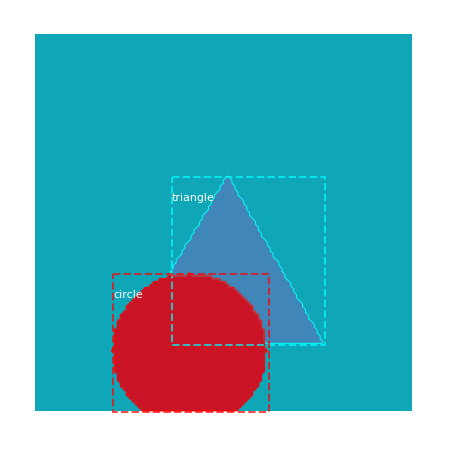

In [11]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:   14.00000  max:  183.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -108.70000  max:   79.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


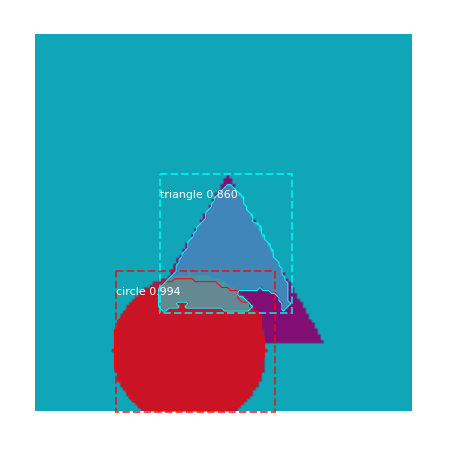

In [12]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [13]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.966666667163372
